In [17]:
from visualize import *
from Feature_encodings import * ## Feature encoding utils
from keras.utils.np_utils import to_categorical
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Loading and pre-processing E3-Target dataset
data_path = 'https://raw.githubusercontent.com/psychemistz/Colab_temp/master/E3target_pred/1metadata.csv'
dataset = pd.read_csv(data_path, index_col=None)

In [3]:
## Extract features
E3_features, Sub_features, Pair_features = Extract_Features(dataset, gap_size=6)
target_label = to_categorical(dataset['Label'])

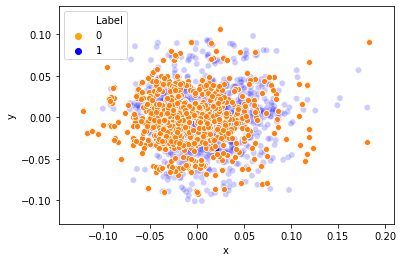

In [4]:
get_PCA_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'input')

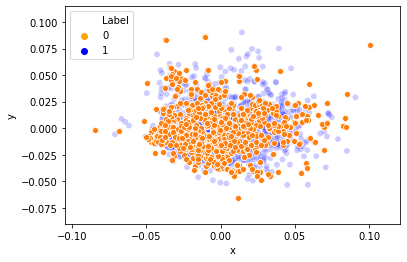

In [5]:
get_PCA_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'output')

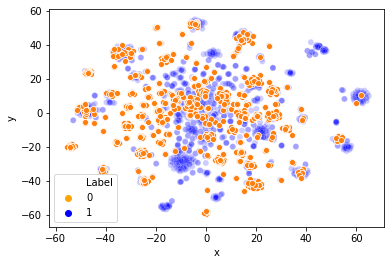

In [6]:
get_TSNE_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'input')

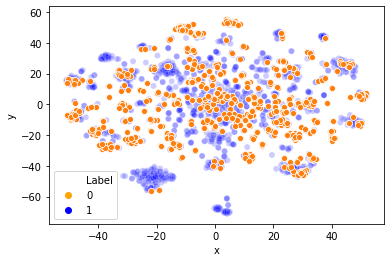

In [7]:
get_TSNE_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'output')

C:\Users\sypark\.conda\envs\E3targetPred\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


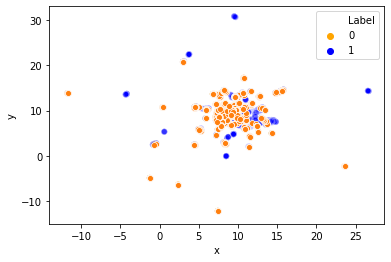

In [8]:
get_UMAP_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'input')

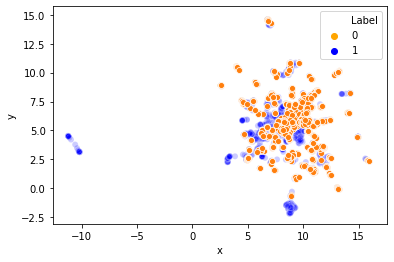

In [9]:
get_UMAP_Embedding(E3_features, Sub_features, Pair_features, target_label, feature_type = 'output')

In [ ]:
def Train_LSE(LV, Gap, lmd, E3_features, Sub_features, Pair_features, target_label):
    ##### Perform Monte-Carlos Simulations for [num_Trials]# of independent Trials####
    
    ## Define parameters explicitly
    LV = LV
    Gap = Gap
    lmd = lmd
   
    Stats =[]            
    ## Divide negative and positive samples
    plist = list(np.asarray(np.where(target_label[:,1]==1)).flatten())
    nlist = list(np.asarray(np.where(target_label[:,1]==0)).flatten())
    
    ## Split Datasets
    train_list, val_list, test_list = split_dataset(plist, nlist, target_label, num_train=570, num_valid=30)
    
    ## Load Datasets
    Xin_train, Xout_train, y_train = load_dataset(E3_features, Sub_features, Pair_features, target_label, train_list)
    Xin_val, Xout_val, y_val = load_dataset(E3_features, Sub_features, Pair_features, target_label, val_list)
    Xin_test, Xout_test, y_test = load_dataset(E3_features, Sub_features, Pair_features, target_label, test_list)
    
    # Define Model
    model = E3_LSE(input_size=Xin_train.shape[1],output_size=Xout_train.shape[1],LV=LV, lmd=lmd)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=300)
    
    checkpoint = ModelCheckpoint('model-best.h5',
                                 verbose=0, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit({'enc_input': Xin_train},
                        {'class_output': y_train, 'decoder_output': Xout_train},
                        validation_data = ({'enc_input': Xin_val},
                                           {'class_output': y_val, 'decoder_output': Xout_val}),
                        epochs=2000, batch_size=1000, callbacks=[checkpoint, es], verbose=0)
    
    del model  # deletes the existing model
    model = load_model('model-best.h5')
    
    ## Calculate Outputs
    y_train_pred, X_train_pred = model.predict(Xin_train,batch_size=1800, verbose=0)
    y_train_pred = to_categorical(y_train_pred.argmax(axis=1))
    MSE_X_train_pred = (np.square(X_train_pred - Xout_train)).mean(axis=1)
    
    y_val_pred, X_val_pred = model.predict(Xin_val,batch_size=200, verbose=0)
    y_val_pred = to_categorical(y_val_pred.argmax(axis=1))
    MSE_X_val_pred = (np.square(X_val_pred - Xout_val)).mean(axis=1)
    
    y_test_pred, X_test_pred = model.predict(Xin_test,batch_size=200, verbose=0)
    y_test_pred = to_categorical(y_test_pred.argmax(axis=1))
    MSE_X_test_pred = (np.square(X_test_pred - Xout_test)).mean(axis=1)
    
    ## Performance Measures
    tr_acc, tr_sen, tr_spe, tr_f1, tr_mcc, tr_bacc, tr_yi, tr_auc = Calculate_Stats(y_train,y_train_pred);
    v_acc, v_sen, v_spe, v_f1, v_mcc, v_bacc, v_yi, v_auc = Calculate_Stats(y_val,y_val_pred);
    t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi, t_auc = Calculate_Stats(y_test,y_test_pred);

    ## Save Measures for later analysis
    Stats.append([tr_acc, tr_sen, tr_spe, tr_f1, tr_mcc, tr_bacc, tr_yi, tr_auc, -10*np.log10(MSE_X_train_pred.mean()),
                  v_acc, v_sen, v_spe, v_f1, v_mcc, v_bacc, v_yi, v_auc, -10*np.log10(MSE_X_val_pred.mean()),
                  t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi, t_auc, -10*np.log10(MSE_X_test_pred.mean())])
    
    ## Print performance messages
    print('CKSAAP-Gap:',Gap, 'LV=',LV, 'Test Youden-index:', t_yi, 'MCC:', t_mcc, 'AUC:', t_auc, 'MSE (dB):', -10*np.log10(MSE_X_test_pred.mean()))
    ## End of single trial
    
    ## save all trials
    Statistics = np.asarray(Stats)
    # filename = 'E3_LSE_STATS_CKSAAP_GAP_' + str(gap) + 'LV' + str(LV) + 'cls' + str(0.99) +'.mat'
    # savemat(filename,{'Statistics':Statistics})
            
    ## Show Classification/Reconstruction Statistics for given LV and gap
    # Show_Statistics('Training Results (MEAN)',Statistics.mean(axis=0)[0:9])
    # Show_Statistics('Validation Results (MEAN)',Statistics.mean(axis=0)[9:18])
    # Show_Statistics('Test Results (MEAN)',Statistics.mean(axis=0)[18:27])

    return Xin_train, y_train, Xin_test, y_test, model

C:\Users\sypark\.conda\envs\E3targetPred\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\sypark\.conda\envs\E3targetPred\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\sypark\.conda\envs\E3targetPred\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


CKSAAP-Gap: 6 LV= 2 Test Youden-index: 0.0 MCC: 0.0 AUC: 0.5 MSE (dB): 50.31854080086813


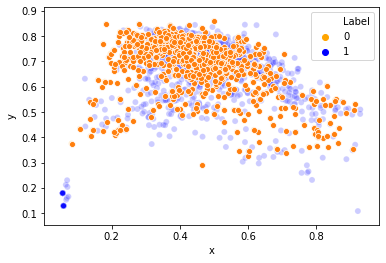

In [18]:
get_LSE_Embedding(E3_features, Sub_features, Pair_features, target_label, LV=2, Gap=6, lmd=1.0)

CKSAAP-Gap: 6 LV= 2 Test Youden-index: 0.5328452623197382 MCC: 0.425295282622166 AUC: 0.7664226311598692 MSE (dB): 49.83121466375843


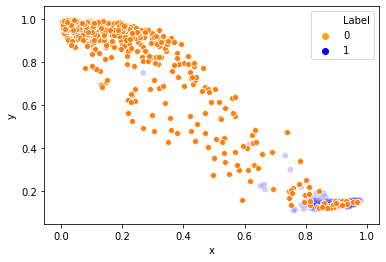

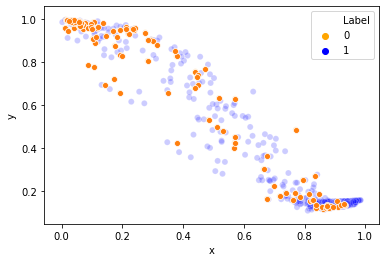

In [23]:
get_LSE_Embedding(E3_features, Sub_features, Pair_features, target_label, LV=2, Gap=6, lmd=0.99)

CKSAAP-Gap: 6 LV= 2 Test Youden-index: 0.49402813412368385 MCC: 0.4008212625636634 AUC: 0.747014067061842 MSE (dB): 17.737276257400598


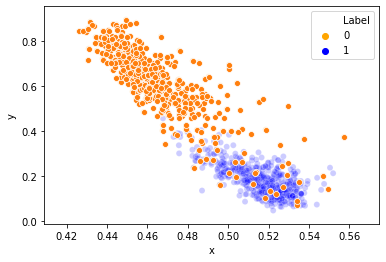

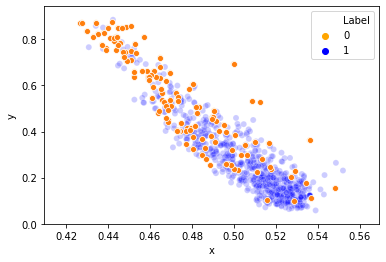

In [22]:
get_LSE_Embedding(E3_features, Sub_features, Pair_features, target_label, LV=2, Gap=6, lmd=0.50)

CKSAAP-Gap: 6 LV= 2 Test Youden-index: 0.5363399097584711 MCC: 0.39460150008571593 AUC: 0.7681699548792357 MSE (dB): 9.634090453876997


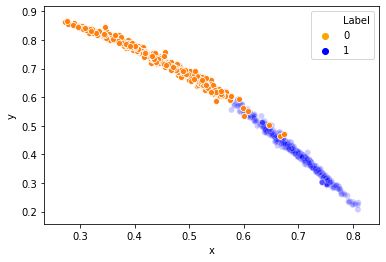

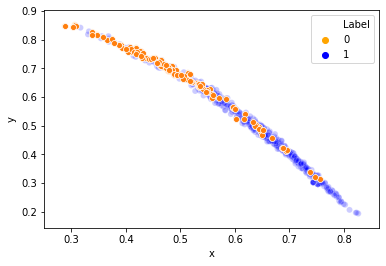

In [21]:
get_LSE_Embedding(E3_features, Sub_features, Pair_features, target_label, LV=2, Gap=6, lmd=0.01)